# ANN Training of Prophet Predictions: Validation Results

In [27]:
%matplotlib inline

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from scipy.stats import binned_statistic

from riskm_all import RMC

Read the 501 validation results. They were obtained after training the Artificial Neural Network (ANN) with 9500 sample scenarios. y is the value for OWN_FUNDS (after 1yr projection) predicted by Prophet, y_pred is the value predicted by the trained ANN.

In [16]:
df = pd.read_csv(os.path.join(RMC.OUTPUT_DIR, 'TR011_MV03R00_OV01R00_DP02R00_train_results.csv'), header=0)
df['SCENARIO'] = df['SCENARIO'].astype('int32')
df.set_index('SCENARIO', inplace=True)

It seems the network delivers the same output for some of the inputs although the true values are different. Nevertheless, the corresponding deviations are rather small.

In [18]:
df[df.duplicated(['y_pred'], keep=False)].sort_values('y_pred')

,y,y_pred,Error,Percentage Error
SCENARIO,,,,
6964,8.441140e+08,844226560.0,-112597.52,-0.013339
8687,8.442059e+08,844226560.0,-20622.85,-0.002443
2789,8.456043e+08,845619264.0,-15004.71,-0.001774
9039,8.456135e+08,845619264.0,-5719.76,-0.000676
3160,8.473199e+08,847332992.0,-13118.30,-0.001548
3474,8.472961e+08,847332992.0,-36921.94,-0.004358


The basic statistics of the predictions are very similar to those of the true (Prophet) values.

In [19]:
df.describe()

,y,y_pred,Error,Percentage Error
count,5.010000e+02,5.010000e+02,501.000000,501.000000
mean,8.469802e+08,8.469854e+08,-5175.444731,-0.000612
std,2.581118e+06,2.580318e+06,113643.763063,0.013425
min,8.395062e+08,8.397891e+08,-598036.620000,-0.070698
25%,8.452645e+08,8.452943e+08,-56381.130000,-0.006661
50%,8.468359e+08,8.467607e+08,-5798.650000,-0.000682
75%,8.486795e+08,8.486252e+08,42574.630000,0.005019
max,8.574122e+08,8.572611e+08,737845.140000,0.087584


Let's look at Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE):

In [28]:
print(math.sqrt(np.mean((df.y - df.y_pred)**2)))
print(np.mean(np.absolute(df.y - df.y_pred) * 100 / df.y))

113648.19337756949
0.008961409082522976


These are the predictions, true values and their difference for the 501 validation samples.

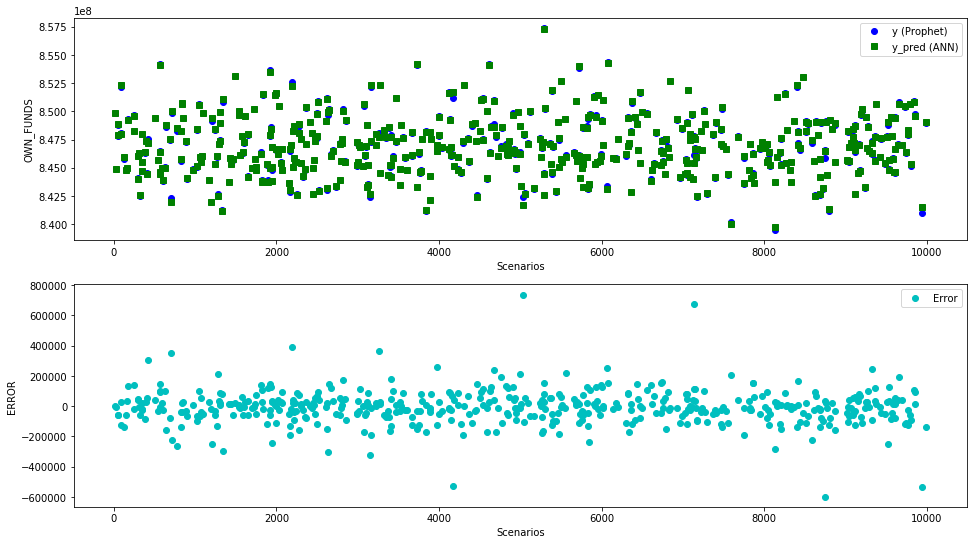

In [47]:
plt.rcParams['figure.figsize'] =(16, 9) 
plt.subplot(211)
plt.xlabel('Scenarios')
plt.ylabel('OWN_FUNDS')
plt.plot(df.y, 'bo', label='y (Prophet)')
plt.plot(df.y_pred, 'gs', label='y_pred (ANN)')
plt.legend()

plt.subplot(212)
plt.xlabel('Scenarios')
plt.ylabel('ERROR')
plt.plot(df.y - df.y_pred, 'co', label='Error')
plt.legend()

The following are the distributions of the true values and of the predictions, as well as the differences and the mean differences in the respective bins. There seems to be a normal distribution of the true values which is pretty much mimicked by the model predictions. Question: How to interpret this normal distribution of the true values (i.e. the prophet model's predictions) across the scenarios? Is this distribution of values denoting the variability of the economic outcomes? Is this the outcome of extensive MC simulations?

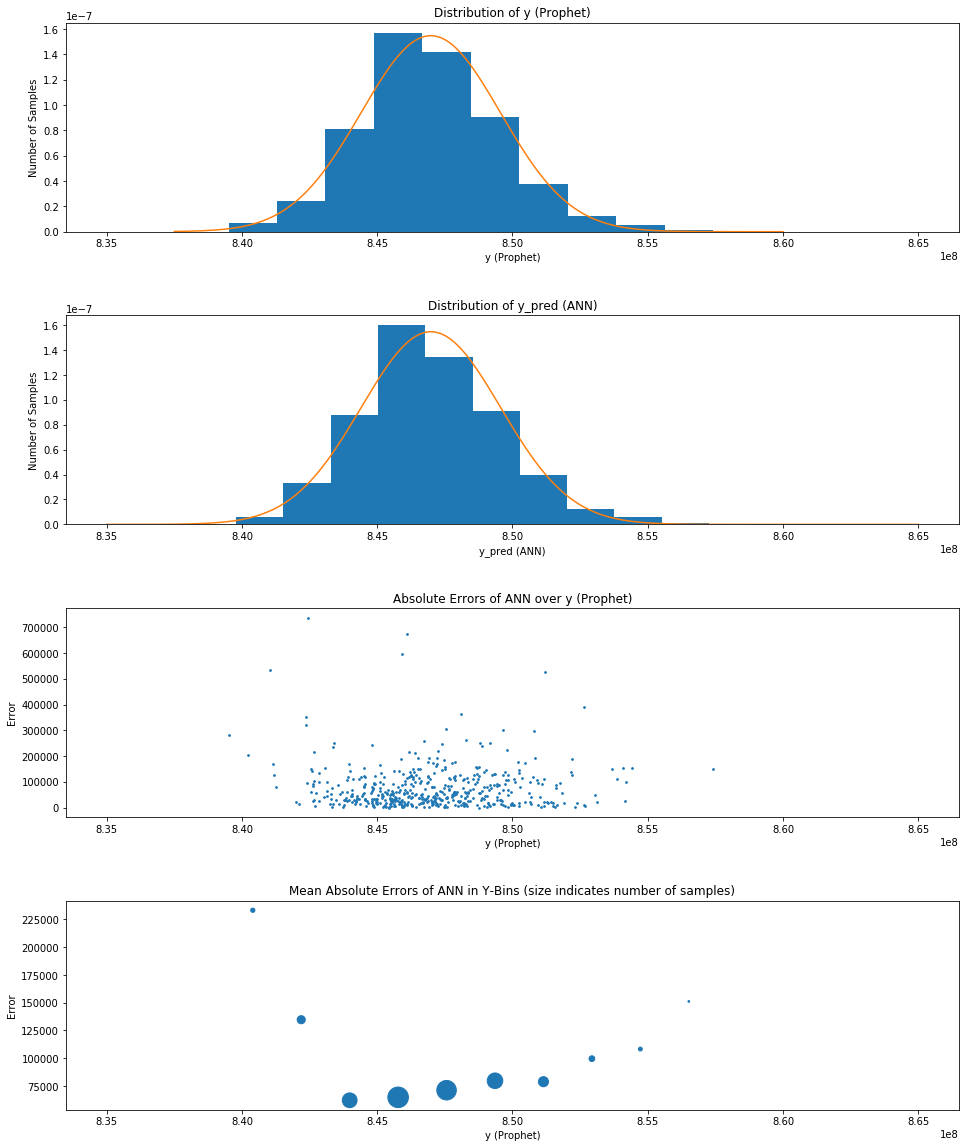

In [75]:
from scipy import stats
import numpy as np

plt.figure(figsize=(16,20))
plt.subplots_adjust(hspace=0.4)
ax1 = plt.subplot(411)
plt.hist(df.y, density=True)
plt.title('Distribution of y (Prophet)')
plt.xlabel('y (Prophet)')
plt.ylabel('Number of Samples')
xt = plt.xticks()[0]
xmin, xmax = min(xt), max(xt)
lnspc = np.linspace(xmin, xmax, len(df.y))
m, s = stats.norm.fit(df.y)
pdf_g = stats.norm.pdf(lnspc, m, s)
plt.plot(lnspc, pdf_g, label='Norm')

plt.subplot(412, sharex=ax1)
plt.title('Distribution of y_pred (ANN)')
plt.xlabel('y_pred (ANN)')
plt.ylabel('Number of Samples')
plt.hist(df.y_pred, density=True)
xt = plt.xticks()[0]
xmin, xmax = min(xt), max(xt)
lnspc = np.linspace(xmin, xmax, len(df.y))
m, s = stats.norm.fit(df.y_pred)
pdf_g = stats.norm.pdf(lnspc, m, s)
plt.plot(lnspc, pdf_g, label='Norm')

plt.subplot(413, sharex=ax1)
plt.title('Absolute Errors of ANN over y (Prophet)')
plt.xlabel('y (Prophet)')
plt.ylabel('Error')
plt.scatter(x=df.y, y=np.abs(df.y - df.y_pred), s=3)

plt.subplot(414, sharex=ax1)
deviation = np.abs(df.y - df.y_pred)
bin_means, bin_edges, binnumber = binned_statistic(x=df.y, values=deviation, statistic='mean', bins=10)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2

occ = np.bincount(binnumber)
occ = np.delete(occ, 0)

plt.title('Mean Absolute Errors of ANN in Y-Bins (size indicates number of samples)')
plt.xlabel('y (Prophet)')
plt.ylabel('Error')
plt.scatter(x=bin_centers, y=bin_means, s=occ * 3)

We can find the samples where the difference is higher than 600000. Strange enough these outliers are in the area where all others samples have the smallest difference between true and predicted. What to make of this? Is this an indication for an anomaly in the prophet model's predictions? Would this be a basic approach for detecting anomalies?

In [76]:
df[np.abs(df.y - df.y_pred) > 600000]

,y,y_pred,Error,Percentage Error
SCENARIO,,,,
5036,8.424432e+08,841705344.0,737845.14,0.087584
7132,8.461047e+08,845430528.0,674130.93,0.079675
